Importing MobileNet Model

In [ ]:
import tensorflow as tf

# Load MobileNetV1 pre-trained model from Keras applications
def load_mobilenet(input_shape=(224, 224, 3)):
    """
    Load the MobileNetV1 model with pre-trained ImageNet weights for feature extraction.
    This model excludes the top classification layer, so it's useful for transfer learning.

    Args:
    - input_shape (tuple): The input shape for the model, default is (224, 224, 3) for RGB images.

    Returns:
    - model: A Keras model with MobileNetV1 pre-trained weights, excluding the top layer.
    """
    mobilenet_v1 = tf.keras.applications.MobileNet(
        input_shape=input_shape,  # Input image shape (224, 224, 3)
        alpha=1.0,                # MobileNet width multiplier
        include_top=False,        # Exclude the fully connected classification layer
        weights='imagenet'        # Use pre-trained weights on ImageNet
    )

    # Choose a layer to extract internal features (e.g., 'conv_pw_13_relu')
    # This layer captures deep features useful for classification
    layer = mobilenet_v1.get_layer('conv_pw_13_relu')

    # Create a new model that outputs the feature map from the selected layer
    feature_model = tf.keras.Model(inputs=mobilenet_v1.input, outputs=layer.output)
    feature_model.trainable = False  # Freeze MobileNetV1 layers to prevent training

    return feature_model

Creating the Classifier: Adding Custom Layers

In [ ]:
class GestureClassifier:
    def __init__(self, num_classes, dense_units=128, learning_rate=0.001):
        """
        Initialize the GestureClassifier, which combines MobileNet feature extraction
        with a custom fully connected network for classification.

        Args:
        - num_classes (int): The number of classes in the classification task.
        - dense_units (int): The number of units in the fully connected layer.
        - learning_rate (float): The learning rate for the Adam optimizer.
        """
        self.num_classes = num_classes       # Number of output classes
        self.dense_units = dense_units       # Number of units in the fully connected layer
        self.learning_rate = learning_rate   # Learning rate for optimizer

        # Load MobileNet feature extractor
        self.feature_model = load_mobilenet_v1()

        # Build the full model
        self.model = self.create_model()

    def create_model(self):
        """
        Creates a Keras model with MobileNetV1 as the feature extractor
        and a custom dense head for classification.
        """
        model = tf.keras.Sequential([
            self.feature_model,  # MobileNet feature extractor
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.dense_units, activation='relu'),
            tf.keras.layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

    def train(self, train_dataset, val_dataset, batch_size=32, epochs=10, steps_per_epoch=None):
        """
        Train the model using training and validation datasets.

        Args:
        - train_dataset: Training data generator.
        - val_dataset: Validation data generator.
        - batch_size: Training batch size.
        - epochs: Number of training epochs.
        """
        early_stopping = EarlyStopping(
            monitor="val_loss",  # Monitor validation loss instead of accuracy
            patience=3,
            restore_best_weights=True,
            verbose=1
        )

        self.model.fit(
            train_dataset,
            batch_size=batch_size,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch or len(train_dataset),
            validation_data=val_dataset,
            callbacks=[early_stopping]
        )

Importing Datasets

In [ ]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = "/content/Train.zip"  # Update with your file name
extract_path = "/content/train"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")
os.listdir(extract_path)  # List contents of the extracted folder

Files extracted to: /content/train


['Scroll_Down', 'Right', 'Left', 'Scroll_Up']

In [ ]:
import zipfile
import os

# Path to the uploaded zip file
zip_path = "/content/Test.zip"  # Update with your file name
extract_path = "/content/test"

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")
os.listdir(extract_path)  # List contents of the extracted folder

Files extracted to: /content/test


['Scroll_Down', 'Right', 'Left', 'Scroll_Up']

Visualizing Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to dataset directories
TRAIN_DIR = "/content/train"  # Replace with the path to your training dataset folder
TEST_DIR = "/content/test"    # Replace with the path to your testing dataset folder

# Define parameters
IMG_HEIGHT = 224  # Height of input images
IMG_WIDTH = 224   # Width of input images
BATCH_SIZE = 1  # Batch size for training and testing
EPOCHS = 10       # Number of training epochs

# Data augmentation for training dataset
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,      # rotation
    width_shift_range=0.2,  # horizontal shift
    height_shift_range=0.2, # vertical shift
    shear_range=0.1,        # shearing
    zoom_range=0.2,          # effect
    validation_split=0.2
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_augmentation(datagen, image_path):
    from tensorflow.keras.preprocessing.image import load_img, img_to_array
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_aug = img_to_array(img)
    img_array = img_to_array(img) / 255.0  # Normalize image


    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original Image")
    plt.axis("off")

    augmented_img = next(datagen.flow(np.expand_dims(img_aug, axis=0), batch_size=1))[0]


    plt.subplot(1, 2, 2)
    plt.imshow(augmented_img.clip(0, 1))  # Clip values between 0 and 1

    plt.title("Augmented Image")
    plt.axis("off")
    plt.show()

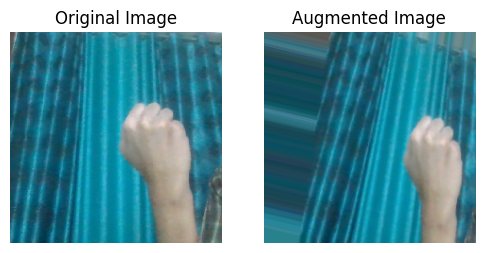

In [ ]:
image_path = "/content/train/Right/Right.5ih366io.ingestion-774b58fbc7-hxp77.jpg"  # Replace with an actual image path
visualize_augmentation(train_datagen, image_path)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
ORIGINAL_TRAIN_DIR = "/content/train"
AUGMENTED_TRAIN_DIR = "/content/augmented_train"  # New directory for augmented images

# Ensure the new directory exists
if not os.path.exists(AUGMENTED_TRAIN_DIR):
    os.makedirs(AUGMENTED_TRAIN_DIR)

In [ ]:
for class_name in os.listdir(ORIGINAL_TRAIN_DIR):
    class_path = os.path.join(ORIGINAL_TRAIN_DIR, class_name)
    save_class_path = os.path.join(AUGMENTED_TRAIN_DIR, class_name)

    if not os.path.exists(save_class_path):
        os.makedirs(save_class_path)

    if os.path.isdir(class_path):  # Ensure it's a folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = load_img(img_path, target_size=(224, 224))  # Load image
            img_array = img_to_array(img)  # Convert to numpy array
            img_array = np.expand_dims(img_array, axis=0)  # Reshape for augmentation

            # Generate and save augmented images
            i = 0
            for batch in train_datagen.flow(img_array, batch_size=1, save_to_dir=save_class_path, save_prefix="aug", save_format="jpeg"):
                i += 1
                if i >= 5:  # Generate 5 augmented images per original image
                    break

In [ ]:
train_generator = train_datagen.flow_from_directory(
    AUGMENTED_TRAIN_DIR,  # Use augmented dataset
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training"
)

Found 228 images belonging to 4 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    AUGMENTED_TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"  # Use this for validation
)

Found 55 images belonging to 4 classes.


Training the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
        monitor="val_loss",  # Monitor validation loss
        patience=3,  # Stop if no improvement after 3 epochs
        restore_best_weights=True,  # Restore the best weights
        verbose=1
    )

In [ ]:
NUM_CLASSES = len(train_generator.class_indices)  # Get number of classes
gesture_classifier = GestureClassifier(num_classes=NUM_CLASSES)

# Train the model
gesture_classifier.train(
    train_dataset=train_generator,
    val_dataset=validation_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.5391 - loss: 16.2333 - val_accuracy: 0.7857 - val_loss: 3.1407
Epoch 2/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.9425 - loss: 0.7093 - val_accuracy: 1.0000 - val_loss: 7.3036e-05
Epoch 3/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - accuracy: 0.9835 - loss: 0.2054 - val_accuracy: 0.9821 - val_loss: 0.2726
Epoch 4/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.9346 - loss: 1.2172 - val_accuracy: 0.9107 - val_loss: 0.7926
Epoch 5/10
228/228 ━━━━━━━━━━━━━━━━━━━━ 42s 162ms/step - accuracy: 0.8635 - loss: 2.1767 - val_accuracy: 0.9643 - val_loss: 0.5614
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


Testing the Model

In [ ]:
ORIGINAL_TEST_DIR = "/content/test"
AUGMENTED_TEST_DIR = "/content/augmented_test"

# Ensure the new directory exists
if not os.path.exists(AUGMENTED_TEST_DIR):
    os.makedirs(AUGMENTED_TEST_DIR)

# Test data augmentation (minimal)
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,      # Small rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2
)

# Iterate through original test images, augment them, and save to the new dataset
for class_name in os.listdir(ORIGINAL_TEST_DIR):
    class_path = os.path.join(ORIGINAL_TEST_DIR, class_name)
    save_class_path = os.path.join(AUGMENTED_TEST_DIR, class_name)

    if not os.path.exists(save_class_path):
        os.makedirs(save_class_path)

    if os.path.isdir(class_path):  # Ensure it's a folder
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)

            img = load_img(img_path, target_size=(224, 224))  # Load image
            img_array = img_to_array(img)  # Convert to numpy array
            img_array = np.expand_dims(img_array, axis=0)  # Reshape for augmentation

            # Generate and save augmented images
            i = 0
            for batch in test_datagen.flow(img_array, batch_size=1, save_to_dir=save_class_path, save_prefix="aug_test", save_format="jpeg"):
                i += 1
                if i >= 3:  # Generate 3 augmented images per original test image
                    break


In [ ]:
test_generator = test_datagen.flow_from_directory(
    AUGMENTED_TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # One-hot encode labels
)

Found 75 images belonging to 4 classes.


In [ ]:
loss, accuracy = gesture_classifier.model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9805 - loss: 0.0729
Test Loss: 0.0890
Test Accuracy: 0.9733


Converting to tflite Format

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(gesture_classifier.model)

# Perform the conversion
tflite_model = converter.convert()

# Save the converted model as a .tflite file
tflite_model_file = 'gesture_classifier_model.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

print(f"Model has been converted and saved as {tflite_model_file}")

Saved artifact at '/tmp/tmp4ojo6izx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_450')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  132317665886480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317665891664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317665899728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317665897616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317665897424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317665893776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317219695184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317219699408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317219695376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132317208052176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1323172080

In [ ]:
# import shutil

# dir_path = "/content/augmented_train"
# shutil.rmtree(dir_path)

# dir_path = "/content/augmented_test"
# shutil.rmtree(dir_path)